## Topic modelling of the corpus

In [1]:
import re
import numpy as np
import pandas as pd
# silence annoying warning
pd.options.mode.chained_assignment = None  # default='warn'

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

# Plotting tools
import pyLDAvis
# may need more from here https://stackoverflow.com/questions/66759852/no-module-named-pyldavis
import pyLDAvis.gensim_models as gensimvis

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


/Users/darya/anaconda3/envs/obesity/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# load data and obesity names
filesdf = pd.read_pickle("../200_data_clean/filesdf.pickle")
# drop unneccessary columns
filesdf = filesdf.drop(['filename', 'encoding', 'confidence', 'fullpath','year', 'numeric_month'], axis=1)



In [3]:
# Convert body to list
bodies = filesdf.body.values.tolist()

# Remove new line characters
bodies = [re.sub('\s+', ' ', sent) for sent in bodies]

# Remove single quotes
bodies = [re.sub("\'", "", sent) for sent in bodies]

# Remove double quotes
bodies = [re.sub('"', "", sent) for sent in bodies]

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

bodies_words = list(sent_to_words(bodies))

[['authorities', 'in', 'mexico', 'city', 'are', 'putting', 'police', 'on', 'diet', 'some', 'of', 'the', 'police', 'officers', 'taking', 'part', 'in', 'the', 'new', 'scheme', 'run', 'by', 'the', 'capitals', 'public', 'security', 'and', 'health', 'ministries', 'have', 'been', 'weighed', 'measured', 'and', 'examined', 'in', 'public', 'ceremony', 'we', 'cant', 'ask', 'them', 'to', 'stop', 'eating', 'tortas', 'big', 'mexican', 'sandwiches', 'and', 'tacos', 'said', 'nora', 'frias', 'local', 'police', 'official', 'yesterday', 'we', 'can', 'tell', 'them', 'that', 'if', 'they', 'eat', 'torta', 'today', 'they', 'have', 'to', 'balance', 'it', 'in', 'the', 'next', 'meal', 'with', 'some', 'vegetables', 'seven', 'out', 'of', 'officers', 'are', 'obese', 'in', 'the', 'mexican', 'capital', 'which', 'is', 'strewn', 'with', 'street', 'food', 'stands', 'according', 'to', 'official', 'figures', 'police', 'officers', 'will', 'undertake', 'monthly', 'medicals', 'under', 'the', 'new', 'campaign', 'and', 'be',

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(bodies_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[bodies_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
bodies_words_nostops = remove_stopwords(bodies_words)

# Form Bigrams
bodies_words_bigrams = make_bigrams(bodies_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
bodies_lemmatized = lemmatization(bodies_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(bodies_lemmatized)

# Create Corpus
texts = bodies_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.173*"sugar" + 0.080*"drink" + 0.038*"water" + 0.031*"soft_drink" + '
  '0.025*"add" + 0.019*"milk" + 0.019*"chocolate" + 0.018*"alcohol" + '
  '0.017*"contain" + 0.017*"consumption"'),
 (1,
  '0.091*"food" + 0.062*"eat" + 0.030*"diet" + 0.027*"healthy" + 0.024*"say" + '
  '0.019*"fat" + 0.017*"fruit" + 0.016*"vegetable" + 0.012*"meal" + '
  '0.010*"make"'),
 (2,
  '0.114*"dog" + 0.062*"animal" + 0.039*"pet" + 0.026*"user" + 0.025*"vic" + '
  '0.018*"human" + 0.018*"illegal" + 0.016*"fertility" + 0.014*"leadership" + '
  '0.014*"owner"'),
 (3,
  '0.030*"day" + 0.030*"exercise" + 0.023*"work" + 0.021*"time" + 0.019*"walk" '
  '+ 0.019*"hour" + 0.015*"minute" + 0.015*"run" + 0.012*"week" + '
  '0.011*"help"'),
 (4,
  '0.032*"disease" + 0.030*"risk" + 0.027*"cancer" + 0.024*"heart" + '
  '0.017*"high" + 0.015*"diabete" + 0.015*"level" + 0.014*"cause" + '
  '0.013*"reduce" + 0.012*"also"'),
 (5,
  '0.038*"government" + 0.023*"say" + 0.019*"obesity" + 0.019*"health" + '
  '0.017*"a

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=bodies_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.07839048677792


/Users/darya/anaconda3/envs/obesity/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/Users/darya/anaconda3/envs/obesity/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/Users/darya/anaconda3/envs/obesity/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/pro


Coherence Score:  0.5002799930787639


In [19]:
import pyLDAvis.gensim_models as gensim_models
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/darya/anaconda3/envs/obesity/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/darya/anaconda3/envs/obesity/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/darya/anaconda3/envs/obesity/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/darya/anaconda3/envs/obesity/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.186239  0.012824       1        1  17.952468
14     0.180465 -0.056095       2        1  13.350028
9      0.189507 -0.036563       3        1  10.124783
5      0.140696  0.083805       4        1   7.853679
15     0.047712  0.150871       5        1   6.987689
1      0.053016 -0.231444       6        1   5.592874
3      0.115769 -0.040095       7        1   5.560307
8      0.162724  0.059101       8        1   4.742613
16     0.118969 -0.004145       9        1   4.393180
4      0.109237 -0.155320      10        1   4.189883
19    -0.019578  0.179732      11        1   3.790812
18     0.078241 -0.008017      12        1   3.789647
11     0.069098  0.157906      13        1   3.030335
10    -0.105166  0.244210      14        1   2.619892
17    -0.042489 -0.203999      15        1   1.991880
12    -0.234576  0.059017      16        1   1.207135
0     -0.198393 -0.130592      17        1   1.165637
7     -0.243762 -0.098536      18        1   0.714299
2     -0.299177 -0.005914      19        1   0.574403
13    -0.308532  0.023253      20        1   0.368456, topic_info=         Term           Freq          Total Category  logprob  loglift
16       food   54819.000000   54819.000000  Default  30.0000  30.0000
371     child   41669.000000   41669.000000  Default  29.0000  29.0000
456    weight   31482.000000   31482.000000  Default  28.0000  28.0000
44        say  144600.000000  144600.000000  Default  27.0000  27.0000
703   service   27415.000000   27415.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
1505     kill     344.345197    3454.504837  Topic20  -4.4945   3.2978
874    monday     249.564535    1357.950549  Topic20  -4.8164   3.9096
2132     fire     266.364777    2052.372493  Topic20  -4.7513   3.5617
1888   sunday     245.260809    2297.233140  Topic20  -4.8338   3.3665
843      free     224.679724    7219.603556  Topic20  -4.9215   2.1337

[1302 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1599      5  0.999071        abc
3439      3  0.270218   academic
3439     14  0.729091   academic
1118      1  0.966959     accept
1118     13  0.032503     accept
...     ...       ...        ...
1283      9  0.304414      youth
1283     13  0.017438      youth
1283     14  0.535590      youth
3057      2  0.997554  youve_got
2111     14  0.995042   zimbabwe

[3039 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 15, 10, 6, 16, 2, 4, 9, 17, 5, 20, 19, 12, 11, 18, 13, 1, 8, 3, 14])

## Key topics:
### Drinks
- (0,
  '0.173*"sugar" + 0.080*"drink" + 0.038*"water" + 0.031*"soft_drink" + '
  '0.025*"add" + 0.019*"milk" + 0.019*"chocolate" + 0.018*"alcohol" + '
  '0.017*"contain" + 0.017*"consumption"')

### Close to topic about food

- (1,
  '0.091*"food" + 0.062*"eat" + 0.030*"diet" + 0.027*"healthy" + 0.024*"say" + '
  '0.019*"fat" + 0.017*"fruit" + 0.016*"vegetable" + 0.012*"meal" + '
  '0.010*"make"'),

### Also some overlap - pets and fertility?
- (2,
  '0.114*"dog" + 0.062*"animal" + 0.039*"pet" + 0.026*"user" + 0.025*"vic" + '
  '0.018*"human" + 0.018*"illegal" + 0.016*"fertility" + 0.014*"leadership" + '
  '0.014*"owner"'),

### Exercise
 - (3,
  '0.030*"day" + 0.030*"exercise" + 0.023*"work" + 0.021*"time" + 0.019*"walk" '
  '+ 0.019*"hour" + 0.015*"minute" + 0.015*"run" + 0.012*"week" + '
  '0.011*"help"'),

- (4,
  '0.032*"disease" + 0.030*"risk" + 0.027*"cancer" + 0.024*"heart" + '
  '0.017*"high" + 0.015*"diabete" + 0.015*"level" + 0.014*"cause" + '
  '0.013*"reduce" + 0.012*"also"'),

- (5,
  '0.038*"government" + 0.023*"say" + 0.019*"obesity" + 0.019*"health" + '
  '0.017*"australia" + 0.015*"cost" + 0.013*"tax" + 0.012*"australian" + '
  '0.012*"state" + 0.012*"public"'),

- (6,
  '0.011*"people" + 0.010*"many" + 0.010*"make" + 0.008*"well" + 0.008*"time" '
  '+ 0.008*"take" + 0.007*"world" + 0.007*"use" + 0.006*"good" + 0.006*"give"'),

- (7,
  '0.200*"food" + 0.081*"junk" + 0.080*"ban" + 0.062*"advertising" + '
  '0.055*"fast" + 0.029*"unhealthy" + 0.025*"mcdonald" + 0.024*"outlet" + '
  '0.019*"obesity" + 0.016*"marketing"'),

- (8,
  '0.057*"health" + 0.041*"say" + 0.027*"hospital" + 0.025*"patient" + '
  '0.019*"medical" + 0.017*"doctor" + 0.015*"surgery" + 0.013*"care" + '
  '0.013*"dr" + 0.013*"need"'),

### Women and money, some overlap with exercise
 - (9,
  '0.045*"cent" + 0.030*"say" + 0.025*"health" + 0.024*"year" + '
  '0.023*"australian" + 0.018*"woman" + 0.017*"people" + 0.016*"rate" + '
  '0.015*"high" + 0.015*"tasmanian"'),

- (10,
  '0.116*"service" + 0.104*"mr" + 0.076*"community" + 0.034*"education" + '
  '0.022*"ms" + 0.017*"act" + 0.016*"teacher" + 0.015*"mrs" + 0.012*"john" + '
  '0.011*"significant"'),

- (11,
  '0.035*"sport" + 0.031*"say" + 0.022*"player" + 0.022*"club" + 0.020*"afl" + '
  '0.017*"labor" + 0.016*"last" + 0.016*"drug" + 0.014*"election" + '
  '0.013*"year"'),

- (12,
  '0.038*"cook" + 0.019*"oliver" + 0.018*"restaurant" + 0.018*"china" + '
  '0.018*"christmas" + 0.015*"ambulance" + 0.015*"chef" + 0.015*"seat" + '
  '0.013*"world" + 0.012*"country"'),

- (13,
  '0.157*"pm" + 0.082*"police" + 0.026*"george" + 0.026*"wilkinson" + '
  '0.022*"ministry" + 0.022*"jail" + 0.019*"hunt" + 0.015*"martin" + '
  '0.015*"saturday" + 0.014*"friday"'),

- (14,
  '0.037*"say" + 0.032*"get" + 0.027*"do" + 0.024*"go" + 0.022*"s" + '
  '0.014*"think" + 0.014*"people" + 0.014*"make" + 0.012*"thing" + '
  '0.012*"want"'),

- (15,
  '0.017*"show" + 0.014*"year" + 0.013*"man" + 0.009*"first" + 0.009*"woman" + '
  '0.009*"love" + 0.008*"new" + 0.007*"old" + 0.006*"tv" + 0.006*"star"'),

- (16,
  '0.113*"child" + 0.063*"school" + 0.042*"parent" + 0.037*"say" + 0.034*"kid" '
  '+ 0.017*"student" + 0.015*"family" + 0.014*"young" + 0.013*"obesity" + '
  '0.013*"childhood"'),

## Separate judgemental articles?
- (17,
  '0.189*"weight" + 0.058*"fat" + 0.050*"lose" + 0.046*"overweight" + '
  '0.045*"obese" + 0.044*"loss" + 0.039*"body" + 0.027*"obesity" + 0.024*"kg" '
  '+ 0.024*"size"'),

## Small topic - reports on research
- (18,
  '0.078*"study" + 0.058*"research" + 0.043*"find" + 0.036*"university" + '
  '0.036*"say" + 0.033*"researcher" + 0.020*"professor" + 0.019*"dr" + '
  '0.017*"brain" + 0.016*"new"'),

## Weird - transport in Tasmania similar to research
- (19,
  '0.028*"city" + 0.027*"tasmania" + 0.019*"car" + 0.017*"road" + '
  '0.016*"state" + 0.015*"transport

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                          id2word=id2word,
                          num_topics=num_topics,
                          random_state=100,
                          update_every=1,
                          chunksize=100,
                          passes=10,
                          alpha='auto',
                          per_word_topics=True)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=bodies_lemmatized, start=10, limit=20, step=1)

/Users/darya/anaconda3/envs/obesity/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/Users/darya/anaconda3/envs/obesity/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/Users/darya/anaconda3/envs/obesity/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/pro

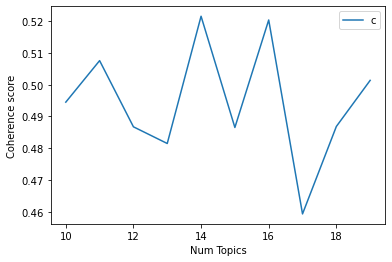

In [30]:
# Show graph
limit=20; start=10; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()